# Health Insurance Cross Sell Prediction

In this notebook, we will apply different Machine Learning methods to predict wether customers who hold a health insurance are also interested in taking a car insurance.

For this purpose, we will use a dataset which is available on kaggle (https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction). It holds information about the customers in a csv file, as well as information about wether a customer is interested in a car insurance. The original dataset is already split into training and test data, however we will only use the training dataset here and treat it as if it was the complete dataset, since we do not have access to the target labels in the original test dataset.


## Libraries

Before doing anything, we need to import the libraries needed for the task. We will use numpy and pandas, two standard libraries for working with data structures, as well as matplotlib and seaborn for visualisation and sklearn for providing Machine Learning methods:

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn 
from tabulate import tabulate

from pandas.api.types import CategoricalDtype, is_numeric_dtype
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import recall_score, precision_score

## Loading the data

An important step in any Machine Learning task is cleaning the data and bringing it into the correct form. In this case, the data is conveniently stored in a single csv file which we can open as a pandas dataframe. The resulting dataframe contains 381109 rows and 12 columns:

In [2]:
data_path = '/home/jonas/Desktop/health_insurance_cross_sell_prediction/data/data.csv'
data = pd.read_csv(data_path)
data.shape

(381109, 12)

Let's have a look at the first rows of the dataframe and the data type of each column:

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
data.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

## Data Cleaning

In the data description on the kaggle website the meaning of the individual columns is explained. Our task is to predict the variable 'Response', which is a binary variable indicating if a customer is interested in taking a car insurance or not. Some of the variables are not encoded correctly yet. We will now adjust the encoding of those variables so that they are better suitable for Machine Learning purposes:

Starting with the 'Gender' column, it is currently encoded as a string, however for the purposes of Machine Learning it would be more practicable as a numeric variable. Thus we change the type and values of the column accordingly:

In [5]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

The 'Region Code' column holds an identifier for the customer's location. Treating it as a numerical variable would be unreasonable since it is not a quantitative measure. This variable is better represented as a string:

In [6]:
data['Region_Code'] = data['Region_Code'].astype(str)

The age of a customer's vehicle would be useful as a numerical value. However in this case, we only have the information wether the car is less than one year, between one and two years, or more than two years old. 

In [7]:
np.unique(data['Vehicle_Age'])

array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object)

We cannot reasonably transform these into numerical values, however leaving them as strings would mean losing information. Instead, we can use the categorical datatype to preserve the ordering between values:

In [8]:
cat_type = CategoricalDtype(categories=['< 1 Year', '1-2 Year', '> 2 Years'], ordered=True)
data['Vehicle_Age'] = data['Vehicle_Age'].astype(cat_type)

Same as for the  gender information, the 'Vehicle Damage' column indicating if a car was damaged in the past is better suited in numerical form:

In [9]:
data['Vehicle_Damage'] = data['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

Same as for the regional code, the 'Policy_Sales_Channel' column is an identifier rather than a quantitative measure, ans hould therefore be changed to a string:

In [10]:
data['Policy_Sales_Channel'] = data['Policy_Sales_Channel'].astype(str)

Having performed the necessary data cleaning steps, our dataset now looks like this:

In [11]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In [12]:
data.dtypes

id                         int64
Gender                     int64
Age                        int64
Driving_License            int64
Region_Code               object
Previously_Insured         int64
Vehicle_Age             category
Vehicle_Damage             int64
Annual_Premium           float64
Policy_Sales_Channel      object
Vintage                    int64
Response                   int64
dtype: object

## Splitting into training and test set

Next, we will split the data set in a training set and a test set, so that we can evaluate our results later. Note that in the original kaggle dataset there is already a test set, however we don't have access to the labels there and therefore we have to create our own test set. We see that our training set holds 304887 rows, and our test set holds 76222 rows.

In [13]:
d_train, d_test = sklearn.model_selection.train_test_split(data, test_size=0.2)

print(d_train.shape)
print(d_test.shape)

(304887, 12)
(76222, 12)


## Exploratory Analysis

As a first step of analysis it is often useful to visualize the distribution the individual variables. This can help
getting an overview about the characteristics of the dataset and spotting potential pitfalls that might occur later in the analysis. Since in our case the explained variable is binary, we can additionally use a stacked histogram to get a sense for potential relationships between single explanatory variables and the explained variable:

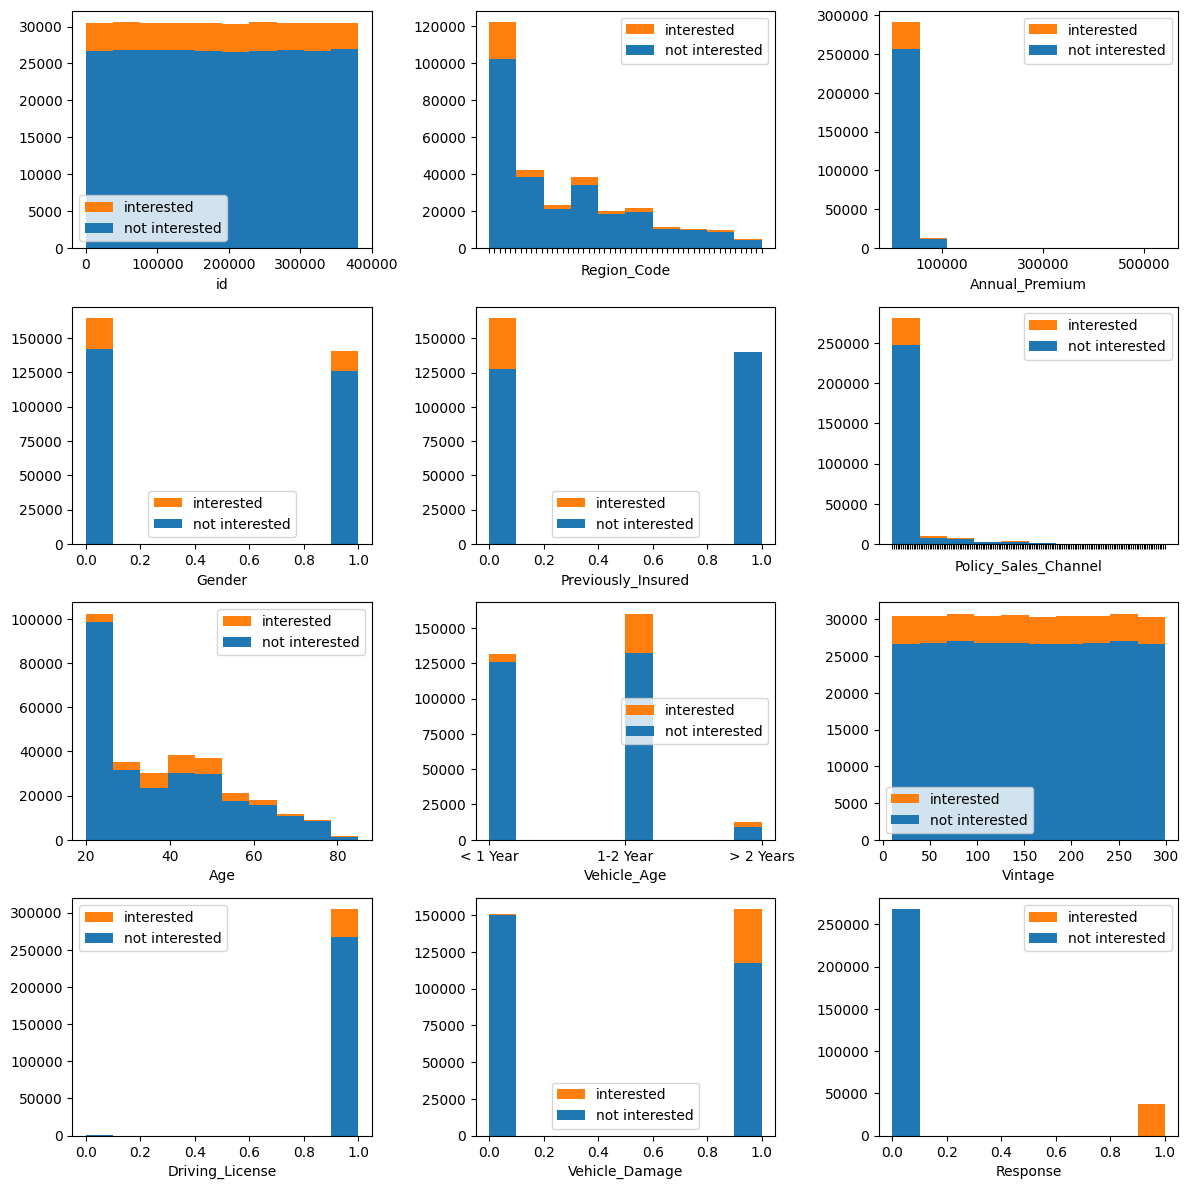

In [14]:
# Split dataset by response variable
d_train_0 = d_train[d_train['Response'] == 0]
d_train_1 = d_train[d_train['Response'] == 1]

# Set up plot matrix
gridsize_y = 4
gridsize_x = 3
fig, axs = plt.subplots(gridsize_y, gridsize_x, figsize=(12,12))

# Generate individual plots with axis label and legend
for i,varname in enumerate(d_train.columns):
    pos_y = i%gridsize_y
    pos_x = int(i/gridsize_y)
    axs[pos_y, pos_x].hist(x=[d_train_0[varname],d_train_1[varname]],
                           histtype='barstacked',
                           label=['not interested', 'interested'])
    axs[pos_y, pos_x].set_xlabel(varname)
    handles, labels = axs[pos_y, pos_x].get_legend_handles_labels() 
    axs[pos_y, pos_x].legend(handles[::-1], labels[::-1])
    
# Avoid overlapping text from axis labels
axs[0,1].set_xticklabels([])
axs[0,2].set_xticks([100000,300000,500000])
axs[1,2].set_xticklabels([])
fig.tight_layout()

We can see that some of the variables are quite uniformly distributed (e.g. 'Vintage'), whereas others are very heterogenous (e.g. 'Age', 'Policy Sales Channel'). As for potential pitfalls, we see that almost every customer in the dataset has a driver's license, meaning that even if the 'Driving_License' variable was a good predictor for our response variable, it would be of very limited use for the Machine Learning task.

Moreover, the stacked histogram reveals that the two variables 'Previously_Insured' and 'Vehicle_Damage' have a visible impact on the response variable. This intuitively makes sense: A customer who already experienced car damage in the past will be more likely to take a car insurance, and a customer who already has a car insurance will be less likely to do so. Another relationship stands out that is less intuitive: Judging from the 'Vehicle_Age' variable, it appears that customers whose vehicle is between 1 and 2 years old are much more likely to take an insurance than customers whose car is less than one year old. Having a closer look, we see that customers whose car is older than 2 years have an even higher chance of being interested in an insurance. So it seems that the readiness to take an insurance increases with the age of the customer's car.


In [15]:
# Closer look at Vehicle_Age: Calculate proportions of interested customers for each value of Vehicle_Age

# Split up dataframes by vehicle age
d_new = d_train[d_train['Vehicle_Age']=='< 1 Year']
d_middle = d_train[d_train['Vehicle_Age']=='1-2 Year']
d_old = d_train[d_train['Vehicle_Age']=='> 2 Years']

# Extract only interested customers
d_new_1 = d_new[d_new['Response']==1]
d_middle_1 = d_middle[d_middle['Response']==1]
d_old_1 = d_old[d_old['Response']==1]

# Calculate proportions
interested_chance_new = len(d_new_1)/len(d_new)
interested_chance_middle = len(d_middle_1)/len(d_middle)
interested_chance_old = len(d_old_1)/len(d_old)

print(interested_chance_new)
print(interested_chance_middle)
print(interested_chance_old)

0.04374047017591771
0.17300252102937874
0.2921479862628786


## Data Preparation II

To be able to use a nominal variable in a Machine Learning model, it is possible to transform it into a set of binary variables by adding a new binary variable for each state of the original variable, indicating if the variable for this sample has this state or not. This process is known as one-hot encoding. We will now one-hot encode the 'Vehicle_Age' variable. The other two nominal variables 'Region_Encoding' and 'Policy_Sales_Channel' we will not use in the further analysis, since one-hot encoding them would increase the number of variables by a huge amount. We also will exclude the 'Driving_License' variable for the reasons described above and the 'id' variable since it does not contain meaningful information for out task. Furthermore, we will rescale the continuous variables 'Annual_Premium' and 'Age' logarithmically to make them more normally distributed, and we subsequently apply a minmax scaling to all contiuous variables.

The variables are then split up into the predictors and the target variable.

In [16]:
# One-Hot encode Vehicle Age
d_train_onehot = pd.get_dummies(data=d_train, columns=['Vehicle_Age'], prefix='V_Age')

def scale_log(x):
    x_rescaled = np.log(x)
    return x_rescaled

def scale_minmax(x):
    x_rescaled = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x_rescaled

# Rescale columns
d_train_onehot['Annual_Premium'] = scale_log(d_train_onehot['Annual_Premium'])
d_train_onehot['Age'] = scale_log(d_train_onehot['Age'])
d_train_onehot['Annual_Premium'] = scale_minmax(d_train_onehot['Annual_Premium'])
d_train_onehot['Age'] = scale_minmax(d_train_onehot['Age'])
d_train_onehot['Vintage'] = scale_minmax(d_train_onehot['Vintage'])


cols_to_drop = ['id', 'Driving_License', 'Region_Code', 
                'Policy_Sales_Channel','Response']


# Split into features and labels
X_train = d_train_onehot.drop(cols_to_drop, axis=1) 
y_train = d_train_onehot['Response']

## Train models

Having prepared the training data adequately, we will now apply a number of common classification methods to our task. Each of the classifiers can be trained with just two lines of code using the scikit-learn library. I will shortly explain each of the classifiers below.

### Logistic Regression


Since our target variable is binary rather than continuous, we cannot use a linear regression to model it. Instead, the logistic regression is used in such cases. It models the log-odds of an event as a linear combination of the predictors. The log-odds is a function that maps probability values to real numbers. The resulting probabilities can then be used to predict the target variable by defining a treshold probability and classifying all observations above that treshold as positive and all observations below as negative. The estimation of the parameters is usually done by the maximum-likelihood method.

Furthermore, we use balanced class weights make sure that the model doesn't only optimize the majority class at the cost of the minority class.


In [18]:
lr = LogisticRegression(class_weight='balanced')
lr_clf = lr.fit(X_train, y_train)

### Support Vector Machine

Support Vector Machines construct a hyperplane that divides the two classes by maximizing the hyperplane's distance to the nearest training samples. Training the model then means finding the parameters of the hyperplane. Once trained, the hyperplane then serves as a decision boundary for the prediction on new samples.

In [ ]:
# Note: Training of the SVM on a local machine can take several hours
svm_clf = svm.SVC(class_weight='balanced')
svm_clf.fit(X_train, y_train) 

### Random Forest

Random Forests are an ensemble method, meaning that they fit multiple classifiers and then generate the final prediction by averaging among the classifiers. In the case of random Forest, those classifiers are decision trees that are fitted on different subsets of the training data. Decision trees aim to subsequently split the data based on an attribute value such that the different classes are separated best. 

In [19]:
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

### Naive Bayes

The Naive Bayes method estimates the probability of the target variable via maximum likelihood estimation. It assumes that the predictor variables are all independent of each other which reduces the number of parameters considerably. Because of this underlying assumption, it is not possible to adjust class weights for this method. One could alternatively reduce the class imbalance by resampling from the minority samples. For now, we will keep using the same training data for each classifier to maintain comparability.

In [20]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

### K Nearest Neighbor

K Nearest Neighbor is a very straightforward classifier that simply determines the class of an unknown sample by taking the majority vote of the classes from the k nearest training samples, according to a given distance metric. There is again no parameter for the class weights. We will instead assign weights to the training sample based on their distance to the  target sample, so that samples further away contribute less. This is not the same mechanism as in the methods above, but might still reduce the impact of the class imbalance to some degree.

In [21]:
knn_clf = KNeighborsClassifier(weights='distance')
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

## Evaluation

Let's see how well the different models perform on unseen test data. For this, we have to one-hot encode, rescale and split the test data in the same way as we did with the training data:

In [22]:
# One-Hot encode Vehicle Age
d_test_onehot = pd.get_dummies(data=d_test, columns=['Vehicle_Age'], prefix='V_Age')

def scale_log(x):
    x_rescaled = np.log(x)
    return x_rescaled

def scale_minmax(x):
    x_rescaled = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x_rescaled

# Rescale columns
d_test_onehot['Annual_Premium'] = scale_log(d_test_onehot['Annual_Premium'])
d_test_onehot['Age'] = scale_log(d_test_onehot['Age'])
d_test_onehot['Annual_Premium'] = scale_minmax(d_test_onehot['Annual_Premium'])
d_test_onehot['Age'] = scale_minmax(d_test_onehot['Age'])
d_test_onehot['Vintage'] = scale_minmax(d_test_onehot['Vintage'])

cols_to_drop = ['id', 'Driving_License', 'Region_Code', 
                'Policy_Sales_Channel','Response']

# Split into features and labels
X_test = d_test_onehot.drop(cols_to_drop, axis=1) 
y_test = d_test_onehot['Response']

We will calculate the accuracy, the precision and the recall of each model. The accuracy measures the fraction of the samples that were classified correctly. The precision measures the fraction of the predicted positives that were classified correctly, and the recall measures the fraction of the true positives that were classified correctly. It is generally useful to report both precision and recall to reveal different aspects of the model, for example how biased the model is towards predicting the majority class.

In [26]:
def get_performance_metrics(clf, X, y):
    """ Calculate performance metrics of a trained classifier"""
    y_pred = clf.predict(X)

    mean_acc = clf.score(X,y)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    return mean_acc, precision, recall



mean_acc_lr, prec_lr, rec_lr = get_performance_metrics(lr_clf, X_test, y_test)
# Note: Evaluating the SVM on a local machine can take several minutes
#mean_acc_svm, prec_svm, rec_svm = get_performance_metrics(svm_clf, X_test, y_test)
mean_acc_rf, prec_rf, rec_rf = get_performance_metrics(rf_clf, X_test, y_test)
mean_acc_gnb, prec_gnb, rec_gnb = get_performance_metrics(gnb_clf, X_test, y_test)
mean_acc_knn, prec_knn, rec_knn = get_performance_metrics(knn_clf, X_test, y_test)


performance_metrics = [
    ['Logistic Regression', mean_acc_lr, prec_lr, rec_lr],
    #['Support Vector Machine', mean_acc_svm, prec_svm, rec_svm],
    ['Random Forest', mean_acc_rf, prec_rf, rec_rf],
    ['Naive Bayes', mean_acc_gnb, prec_gnb, rec_gnb],
    ['K Nearest Neighbor', mean_acc_knn, prec_knn, rec_knn]
]

head = ['Classifier', 'Accuracy', 'Precision', 'Recall']

print(tabulate(performance_metrics, headers=head))

Classifier             Accuracy    Precision    Recall
-------------------  ----------  -----------  --------
Logistic Regression    0.639868     0.253585  0.975836
Random Forest          0.850424     0.30706   0.161549
Naive Bayes            0.721275     0.286935  0.83613
K Nearest Neighbor     0.846042     0.307928  0.190989


## Conclusion

In this notebook, we trained 5 different classification models to predict wether a customer who already has a health insurance is interested in taking a car insurance, based on demographic and business-related customer data. The overall best accuracy scores were reached by the Random Forest and the K Nearest Neighbor classifiers while the Logistic Regression model had the highest recall score. Naive Bayes hit a middle ground with both comparably high recall and accuracy scores. The results of all the classifiers are still quite low, considerung that a model which always predicts the majority class would have likely reached similar or better accuracy scores. Further steps to improve the models could be tuning the hyperparameters via a grid search, or using a different model like a Deep Neural Network which was not feasible here because of runtime and hardware limitations. For the task at hand it is conceivable that a high recall is much more desirable than a high precision, since it might be important to identify every customer who is willing to take a car insurance in order to approach them: Every interested customer who is not approached means lost revenue, however approaching a customer who is not interested might only be a very small expense. Thus, the logistic regression model might be promising for this particular use case.